In [13]:
import heapq
import scipy.stats as sts
import random
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import numpy as np
import uuid

In [14]:
class Event:
    '''
    The code is taked from pre class work 2.2 
    
    creates event objects and assigns the time when it should be executed, the function that should be executed 
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        The code is taked from pre class work 2.2 
        
        used for comparison of two events to determin which one goes earlier  
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        The code is taked from pre class work 2.2 
        
        Run an event by calling the function
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    The code is taked from pre class work 2.2 
    
    Implement an event schedule using a heap based priority queue. 
    '''
    
    def __init__(self):
        """
        input: 
            now -> int: starts with 0
            priority_queue -> list: the queue for the events 
            
        """
        self.now = 0  
        self.priority_queue = []  
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        """
        Add an event to the schedule at a particular point in time.
        input: 
            timestap -> float: timestamp at which the event should be scheduled.
        """
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        """
        adding event in the schedule after the set period of time 
        
        input: 
            interval -> int: time to pass before the next action
            function -> the action that should be performed after the time interval
        """
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        """
        getting the time for the next event 
        """
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        """
        getting the next event from the priority queue and run it.
        """
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        """
        return a string representation of the Schedule object.
        """
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        """
        printing the actions 
        """
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')



class SeniorOfficer():
    """
    performs the secondary security check. has its own queue of the blocked queues with passanegrs. 
    Processes passanger according to trunkated normal distribution (120, 120)
    """

    def __init__(self, mu_senior_service, sigma_senior_service):
        self.block_list = []
        self.q_list = []
        self.status = 0
        self.mu_senior_service = mu_senior_service
        self.sigma_senior_service = sigma_senior_service
        self.extra_service_time_generator = None
        
    def set_service_time_generator(self, generator_function):
        """
        generating the distribution to draw samples for the service time 
        """
        self.service_time_generator = generator_function
        
    def set_q_list(self, q_list):
        """
        get the list of all queues 
        """
        self.q_list = q_list

    def reset_status(self):
        """
        become idle 
        """
        self.status=0

    def set_status(self):
        """
        become occupied 
        """
        self.status=1
    
    def get_block_list(self):
        return(self.block_list) 

    def get_status(self):
        """
        getter function for the status 
        0 --> NOT busy, 1--> IS busy
        """
        return(self.status)

    def find_queue_by_id(self, q_list, target_id):
        """
        finds the queue object in the list of all queues based on it's id in the blocking list 
        input: 
            q_list -> list: contains Queue objects 
            target_id:  contains the id of the individual queue 
        output: 
            the queue we need 
        """
        for queue in q_list:
            if queue.id == target_id:
                return(queue)

    def start_working_on_q(self, schedule):
        """
        function for processing the queue, uses recursion
        input: 
            scedule -> obj from class Schedule 
        
        """
        
        if self.get_status(): #if not idle 
            in_progress_q_id = self.block_list[0] #get the queue 
            q_to_process = self.find_queue_by_id(self.q_list, in_progress_q_id) 
            extra_service_time = self.extra_service_time_generator() #get the servie time 
            
            schedule.add_event_after(extra_service_time, q_to_process.finish_serving_person) #process queue 
            schedule.add_event_after(0, self.start_working_on_q) #recursion: work on the next queue 
            print(f"WORKING ON {in_progress_q_id}")
        else: 
            print("nothing to work on")        
    
    def add_blocked_q(self, queue):
        """
        adds the queue to the list (queue) 
        """
        self.block_list.append(queue)
    
    def pop_blocked_q(self):
        """
        deletes the queue from the list (dequeue)
        """
        self.block_list.pop(0)
    

class Queue:
    """
    code is adapted from pre class work 2.2 
    processes passangers thought the mandatory security, sends them to additional security is needed. 
    records the key times to calcualte the metrics     
    """
    
    def __init__(self, mu_service, sigma_service, mu_senior_service, sigma_senior_service, senior_officer):
        self.people_in_queue = 0 
        self.people_being_served = 0
        self.blocked = False 
        self.id = uuid.uuid4() #unique id for each queue to be identifiable by the senior officer 

        self.block_time=[]
        self.unblock_time=[]
        self.start_service_times = []
        self.finish_service_times = []
        
        self.senior_officer = senior_officer
        self.mu_senior_service = mu_senior_service
        self.sigma_senior_service = sigma_senior_service
        self.mu_service = mu_service
        self.sigma_service = sigma_service

        
    def generate_trunknorm(self, mu, sigma):
        """
        generates a list of 100 samples of trunkated normal distribution 
        input: 
            mu -> int: the mean of the distribution 
            sigma -> int: standard deviation 
        output: 
            distribution_sample -> list: list of the distribution 
        """
        lower_z = (0 - mu) / sigma
        upper_z = (np.inf - mu) / sigma
        distribution = truncnorm(lower_z, upper_z, loc=mu, scale=sigma)
        distribution_sample = distribution.rvs(size=100) 
        return distribution_sample
    
    def service_time(self, mu, sigma): 
        return(1/random.choice(self.generate_trunknorm(mu,sigma)))

    def add_person(self, schedule):
        """
        adds person to the queue and if there is nodoby in the queue starts serving immediately 
        """
        self.people_in_queue += 1
        if self.people_being_served < 1:
            schedule.add_event_after(0, self.start_serving_person)
    
    def ask_for_officer(self, schedule):
        """
        this function is called if a passenger needs an additional sceening 
        """
        if self.senior_officer.status == 1: #if senior officer is busy -> move to his queue 
            self.senior_officer.add_blocked_q(self.id) 
        else:
            self.senior_officer.status = 1 #become busy 
            service_time = random.choice(self.generate_trunknorm(self.mu_service, self.sigma_senior_service))
            schedule.add_event_after(service_time, self.finish_serving_person) #process 
            
    def start_serving_person(self, schedule):
        """
        the passenger starts serving process 
        """
        if random.random() < 0.05: #if additional sceening needed
            self.people_in_queue -= 1
            self.people_being_served += 1
            
            self.blocked = True #get blocked 
            self.block_time.append(schedule.now)  
            schedule.add_event_after(0, self.ask_for_officer) #call the seniour officer 
            #print("BLOCKING OCCURED AT")
            #print(f"{schedule.now} in Q {self.id}")

        else:
            self.people_in_queue -= 1
            self.people_being_served += 1
            self.start_service_times.append(schedule.now) 
            schedule.add_event_after( #process passenger
                    self.service_time(self.mu_service, self.sigma_service), self.finish_serving_person)
        

    def finish_serving_person(self, schedule):
        """
        unblocking of the queue happens here, at the end of the function the service is fully completed  
        """
        self.people_being_served -= 1
        
        if self.blocked: 
            self.blocked = False #unblock 
            self.senior_officer.reset_status() 
            self.unblock_time.append(schedule.now)
            #test for blocking 
            #print("BLOCKING WAS LIFTED AT")
            #print(f"{schedule.now} in Q {self.id}")
            #print("******************")
            #print("BLOCKING LIST LOOKS LIKE")
            #print(f"{self.senior_officer.get_block_list()}")
            #print(f"officer status{self.senior_officer.get_status()}")    
            #now as the officer is free they have to check if there is more work to be done 
            if len(self.senior_officer.get_block_list())>0:
                schedule.add_event_after(0, self.ask_for_officer) 
        if self.people_in_queue > 0:
            # There are more people in the queue so serve the next person
            schedule.add_event_after(0, self.start_serving_person)
        self.finish_service_times.append(schedule.now)

    def get_blocking_times(self):
        """
        getter for the blocking times (needed for graph)
        """
        return(self.block_time)
    
    def get_unblocking_times(self):
        """
        getter for unblocking times (needed for graph)
        """
        return(self.unblock_time)
    
  


class Airport:
    """
    set up the airport 
    the queues will be creased here
    seniour officer will be created here
    airport will ahve 2 main function: 
        adding passangers that arrive accoring to the possion proccess
        starting accepting passangers and passing them into the queues 
    """
    def __init__(self, arrival_rate, mu_service, sigma_service, mu_senior_service, sigma_senior_service, num_queues):
        """
        since most of the things are being set up here we need to pass the main arguments for the model here
        """
        self.senior_officer = SeniorOfficer(mu_senior_service, sigma_senior_service)
        self.queues = [Queue(mu_service, sigma_service, mu_senior_service, sigma_senior_service, self.senior_officer) for _ in range(num_queues)]
        self.senior_officer.set_q_list(self.queues)
        self.senior_officer.set_service_time_generator(self.queues[0].generate_trunknorm(mu = mu_senior_service, sigma = sigma_senior_service))
        self.arrival_distribution = sts.expon(scale = 1/arrival_rate)
        self.arrival_times = []

    def add_person(self, schedule):
        """
        finding the shortest queue and adding a person there 
        """
        self.arrival_times.append(schedule.now)
        #the next line of code was generated by chat GPT
        shortest_queue = min(self.queues, key=lambda q: q.people_in_queue) #find the shortest queue 
        shortest_queue.add_person(schedule)
        #schedule when to add another person
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_person)
        

    def run(self, schedule):
        # Schedule when the first person arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_person)
     
    
def run_simulation(arrival_rate, mu_service, sigma_service, \
                   mu_senior_service, sigma_senior_service, \
                   run_until, num_queues, show_process, show_interval):
    """
    the function that runs the airport simpulation 
    here we create the airport object and launch it
    we also use data to calculate the metrics 
    """
    schedule = Schedule()
    airport = Airport(arrival_rate, mu_service, sigma_service, mu_senior_service, sigma_senior_service, num_queues)
    airport.run(schedule)
    events = 0
    time_stamps = []
    
    # Initialize a list of empty lists for each queue to calculate metrics
    people_in_queue = [[] for _ in range(num_queues)]
    wait_times_per_queue = [[] for _ in range(num_queues)]
    
    #blocking and unbloking times will be used to illustrate the process on the graph
    blocking_times_in_queue = [ [] for _ in range(num_queues)]
    unblocking_times_in_queue = [ [] for _ in range(num_queues)]
    
    senior_officer_status = []   
    max_length = 0
    queue_lengths = []
    
    #the simulation is time contrained
    while schedule.next_event_time() < run_until:
        time_stamps.append(schedule.next_event_time())
        events += 1
        schedule.run_next_event()
        senior_officer_status.append(airport.senior_officer.get_status())
        
        
        # Store the number of people in each queue at every event
        for i, queue in enumerate(airport.queues):
            people_in_queue[i].append(queue.people_in_queue)
            #calculate waiting time 
            for start_service_time, arrival_time in zip(queue.start_service_times, airport.arrival_times):
                wait_time = start_service_time - arrival_time
                wait_times_per_queue[i].append(wait_time)
                
        #calculate the queue length and max queue length 
        current_num_people_in_one_queue = sum(queue.people_in_queue for queue in airport.queues)/num_queues
        queue_lengths.append(current_num_people_in_one_queue/num_queues)
        if current_num_people_in_one_queue > max_length:
            max_length = current_num_people_in_one_queue
 
    for i, queue in enumerate(airport.queues):
        #populate the lists of blocking/unblocking times 
        blocking_times_in_queue[i] = queue.get_blocking_times()
        unblocking_times_in_queue[i] = queue.get_unblocking_times()
        
            
    #calculate metrics
    avg_length = queue_lengths[-1] #varage length at the end of the simulation 
    avg_wait_time = np.mean(np.mean(wait_times_per_queue))


    if show_process:
        fig, ax = plt.subplots(figsize=(15,10))
        for i, pq in enumerate(people_in_queue):
             ax.plot(time_stamps, pq, label=f'Queue {i + 1}')
        #Plotting senior officer status    
        a_status =ax.twinx()
        a_status.scatter(time_stamps, senior_officer_status, label="Officer status", ls="dashed", color="purple")
        #show the blocking 
        for i, queue in enumerate(airport.queues):
                for k in blocking_times_in_queue[i]:
                    ax.axvline(x=k, color='red') # Blockig in red
                for m in unblocking_times_in_queue[i]:
                    ax.axvline(x=m, color='green') # Unblocking in green
        ax.set_title("M/G/1 Queue Simulation")
        ax.set_xlabel("Time (min)")
        ax.set_ylabel("People in Queue")
        ax.legend()
        fig.show()

#    Test for blocking times (works only for 1 q)
#    average_blocking_time = np.average(np.array(unblocking_times_in_queue)\
#                                        - blocking_times_in_queue)
#    print("******AVERAGE BLOCKING TIME*****")
#    print(average_blocking_time) 

    if show_interval:
        #calculate 95% confidence interval on the avg queue length 
        for i, pq in enumerate(people_in_queue):
            m = np.mean(pq)
            m_approx = round(m, 2)
            t = sts.sem(pq)
            t_approx = round(t, 2)
            print(f'95% confidence interval for Queue {i+1}:', [m_approx + 1.96*t_approx, m_approx - 1.96*t_approx])
    return airport, avg_length, max_length, avg_wait_time
    



/var/folders/k_/yc0ykmqs4l725qknvzyg0mmc0000gn/T/ipykernel_93736/453085120.py:433: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


95% confidence interval for Queue 1: [145.51600000000002, 134.344]
95% confidence interval for Queue 2: [146.0252, 134.7748]
95% confidence interval for Queue 3: [145.6848, 134.3952]


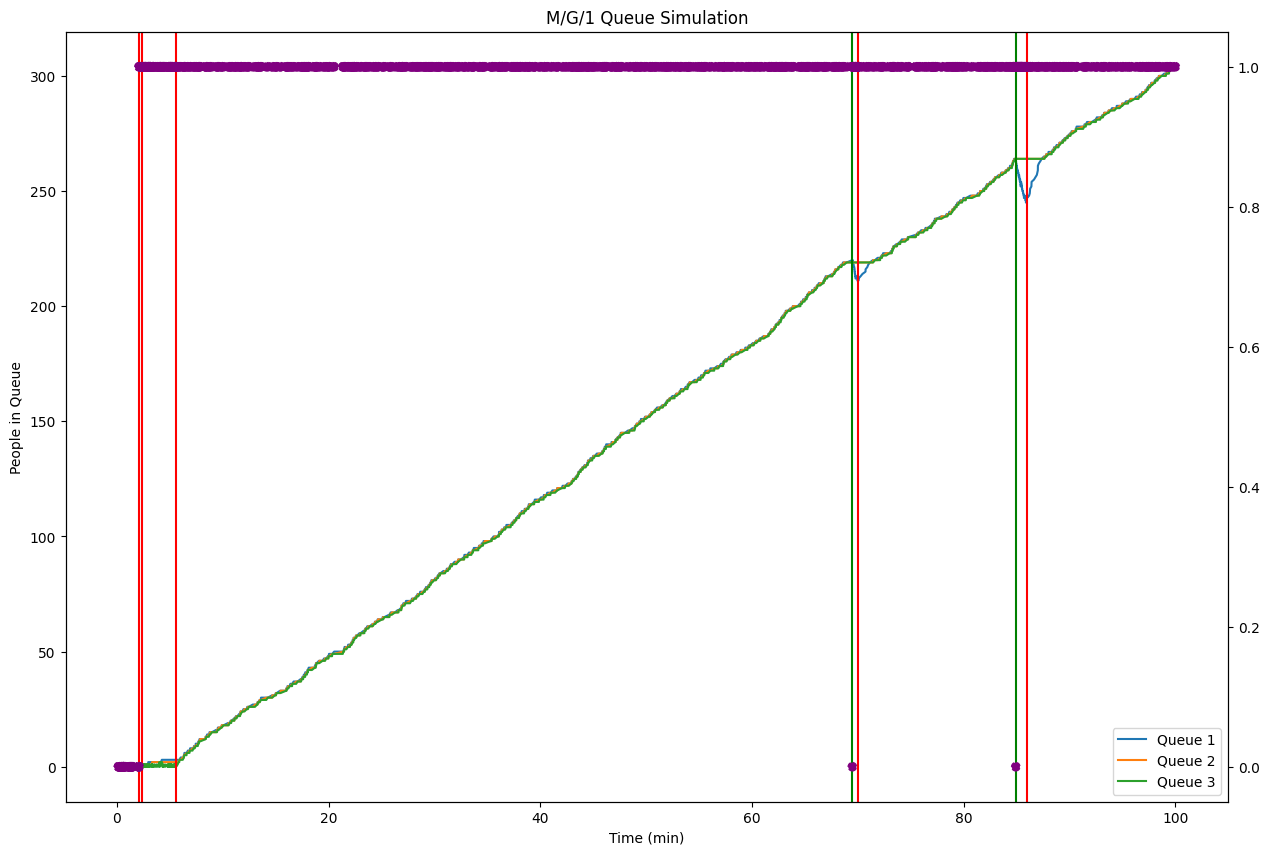

In [15]:
airport = run_simulation(arrival_rate= 10,\
                        mu_service= 30, \
                        sigma_service= 10,
                        mu_senior_service = 120, \
                        sigma_senior_service = 120,\
                        run_until= 100,\
                        num_queues = 3, show_process = True, show_interval = True)


In [22]:
list_avg_length = []
list_max_length = []
list_avg_wait_time = []
for i in range(10,100):
    airport, avg_length, max_length, avg_wait_time = run_simulation(arrival_rate= 10,\
                        mu_service= 30, \
                        sigma_service= 10,
                        mu_senior_service = 120, \
                        sigma_senior_service = 120,\
                        run_until= 100,\
                        num_queues = i, show_process = False, show_interval = False)
    
    list_avg_length.append(avg_length)
    list_max_length.append(max_length)
    list_avg_wait_time.append(avg_wait_time)

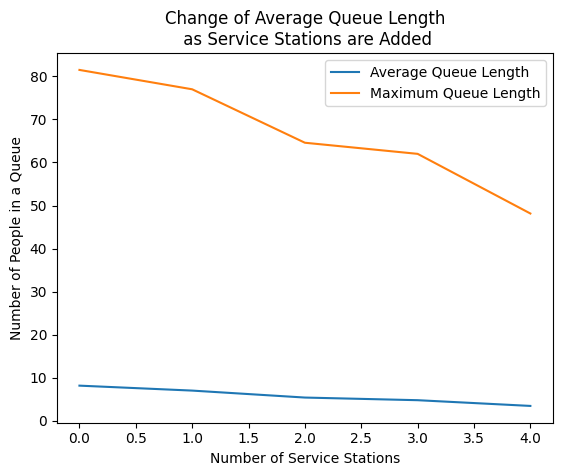

In [23]:
plt.plot(list_avg_length, label = 'Average Queue Length')
plt.plot(list_max_length, label = 'Maximum Queue Length')
plt.title('Change of Average Queue Length\n as Service Stations are Added')
plt.xlabel('Number of Service Stations')
plt.ylabel('Number of People in a Queue')
plt.legend()
plt.show()

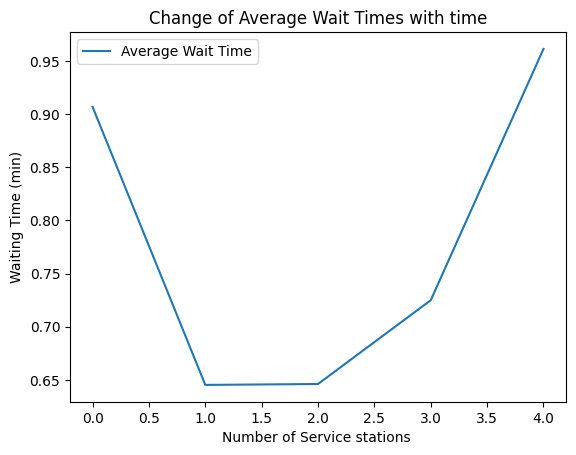

In [24]:
plt.plot(list_avg_wait_time, label = 'Average Wait Time')
plt.title('Change of Average Wait Times with time')
plt.xlabel('Number of Service stations ')
plt.ylabel('Waiting Time (min)')
plt.legend()
plt.show()


In [25]:

def calculate_confidence_interval(data, confidence=0.95):
    """
    Calculate a confidence interval for a list of data.

    input:
     data -> list: data on which we would perform calculations 
     confidence -> float: desired confidence level

    output:
     confidence_interval ->tuple: A tuple containing the lower and upper bounds of the confidence interval.
    """
    data = np.array(data)
    mean = np.mean(data)
    n = len(data)
    standard_error = sts.sem(data)
    margin_of_error = standard_error * sts.t.ppf((1 + confidence) / 2, n - 1)
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    return (round(lower_bound, 2), round(upper_bound, 2))


In [26]:
calculate_confidence_interval(list_avg_length, confidence=0.95)

(3.44, 8.05)